In [39]:
import logging

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

%matplotlib inline

Automatically created module for IPython interactive environment


In [34]:
# Download the data, if not already on disk and load it as numpy arrays
from skimage import io,transform,color
import os
from tqdm import tqdm

DATASET_PATH = '/Users/houtonglei/OneDrive - stu.hqu.edu.cn/数学建模/2021美赛/2021_ICM_ProblemC/pic_dataset/'
TRAIN_SET = DATASET_PATH + 'train/'
labels = ['neg','pos']
neg = []
pos = []
for label in labels:
    files = os.listdir(TRAIN_SET + label)
    for file in tqdm(files):
        try:
            im = io.imread(os.path.join(TRAIN_SET, label, file))
            if label=='neg':
                neg.append(color.rgb2gray(transform.resize(im,(64,64))).flatten())
            elif label=='pos':
                pos.append(color.rgb2gray(transform.resize(im,(64,64))).flatten())
        except Exception:
            pass

  4%|▍         | 132/3097 [00:06<02:36, 18.97it/s]<ipython-input-34-1b3db2650962>:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  neg.append(color.rgb2gray(transform.resize(im,(64,64))).flatten())
 18%|█▊        | 542/3097 [00:29<02:56, 14.47it/s]/Users/houtonglei/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 496 bytes but only got 0. Skipping tag 0
  warnings.warn(
/Users/houtonglei/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 240 bytes but only got 0. Skipping tag 0
  warnings.warn(
/Users/houtonglei/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skippi

In [36]:
import sklearn
import numpy as np

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dataset = sklearn.utils.Bunch()
dataset.data = np.array(pos + neg)
dataset.target = np.array([1]*14+[0]*3097)
dataset.target_names = ['pos','neg']

Total dataset size:
n_samples: 4011
n_features: 4096
n_classes: 2
Extracting the top 150 eigenfaces from 2333 faces
done in 0.721s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.057s
Fitting the classifier to the training set
done in 28.358s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting people's names on the test set
done in 0.024s
              precision    recall  f1-score   support

         pos       1.00      1.00      1.00       775
         neg       0.00      0.00      0.00         3

    accuracy                           1.00       778
   macro avg       0.50      0.50      0.50       778
weighted avg       0.99      1.00      0.99       778

[[775   0]
 [  3   0]]


/Users/houtonglei/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


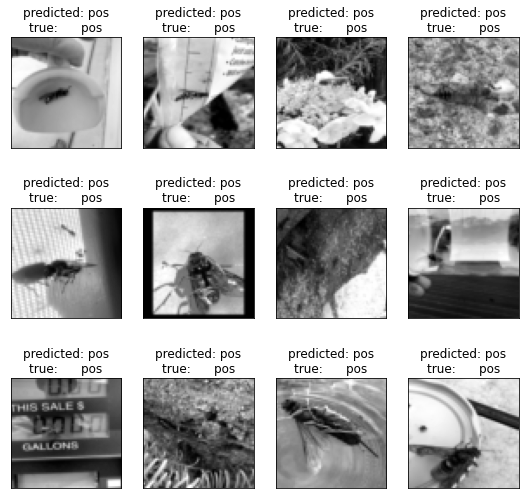

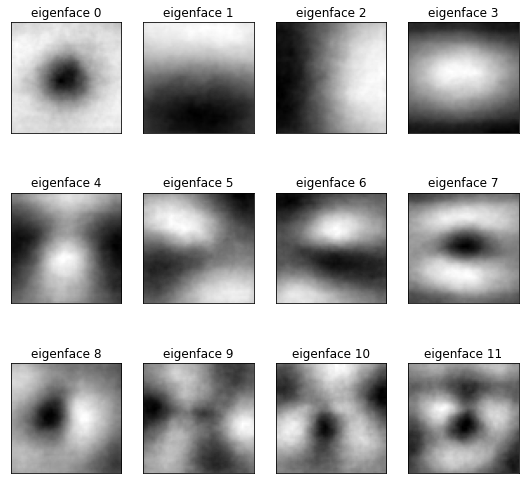

In [38]:
from sklearn.model_selection import train_test_split
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = [4011, 64, 64]

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = dataset.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = dataset.target
target_names = dataset.target_names
n_classes = 2

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [ ]:
from time import time
from sklearn.decomposition import PCA

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()
